In [141]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import nibabel as nb 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib import colors
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_20'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
save_fig_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem', 'BasalGanglia'
            ]

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest – mehalonobis distance for SN,STN,Puta


In [142]:
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_STRx']    = (df['L_Puta'] + df['L_Caud']) / 2
    df['R_STRx']    = (df['R_Puta'] + df['R_Caud']) / 2
    
    df['L_STRxx']    = (df['L_Puta'] + df['L_Caud'] + df['L_Pall']) / 3
    df['R_STRxx']    = (df['R_Puta'] + df['R_Caud'] + df['L_Pall']) / 3    

    df['STRx']     = (df['R_STRx'] + df['L_STRx']) / 2

    df['STRxx']     = (df['R_STRxx'] + df['L_STRxx']) / 2

    df['LBrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['RBrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['LBrainStemx']    = (df['L_STN'] + df['L_SN']) / 2
    df['RBrainStemx']    = (df['R_STN'] + df['R_SN']) / 2
    df['BrainStemx']    = (df['LBrainStemx'] + df['RBrainStemx']) / 2
    
    
    df['LBasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] +  df['L_Accu']) / 4
    df['RBasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] +  df['R_Accu']) / 4
    
    df['BrainStem'] = (df['LBrainStem'] + df['RBrainStem']) / 2
    df['BasalGanglia'] =(df['LBasalGanglia'] + df['RBasalGanglia']) / 2
    
    
    df['L_ALL_NUCLEI'] = (df['LBrainStem'] + df['LBasalGanglia'] + df['L_DN']) / 3
    df['R_ALL_NUCLEI'] = (df['RBrainStem'] + df['RBasalGanglia'] + df['R_DN']) / 3
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) /3
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True)#.drop(drop_c, axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 

controls_a['Population'] = 0
patients_a['Population'] = 1
    
controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

DF_ALL =pd.concat([controls_a, patients_a], axis=0)


/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/NUC/BATP/FIRST_HYBRID-L_Puta_first_thr.nii.gz


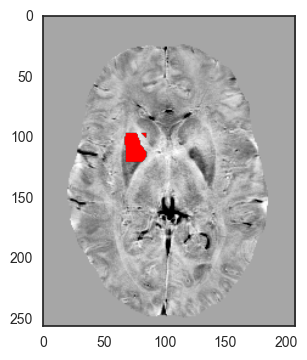

In [143]:
subject = 'BATP'
Zcut = 67
cmap = colors.ListedColormap('red')

print os.path.join(datadir[:-6],'NUC', subject,'FIRST_HYBRID-L_Puta_first_thr.nii.gz')

#for subject in controls_a.index:
mrs  = np.rot90(nb.load(os.path.join(datadir[:-6],'MRS', subject, 'STR_FLASH_BIN.nii.gz')).get_data()) 
qsm  = np.rot90(nb.load(os.path.join(datadir[:-6],'NUC', subject, 'QSM_norm.nii.gz')).get_data()) 
put  = np.rot90(nb.load(os.path.join(datadir[:-6],'NUC', subject,'FIRST_HYBRID-L_Puta_first.nii.gz')).get_data())
cau  = np.rot90(nb.load(os.path.join(datadir[:-6],'NUC', subject,'FIRST_HYBRID-L_Caud_first.nii.gz')).get_data())
pal  = np.rot90(nb.load(os.path.join(datadir[:-6],'NUC', subject,'FIRST_HYBRID-L_Pall_first.nii.gz')).get_data())
     
for i in [put,cau,pal,mrs]:
    i[i>0]=1
    i[i==0]=0
    
data = (put + cau + pal) * mrs 
data[data==0]=np.nan
plt.imshow(qsm[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.2, vmax = .2)
plt.imshow(data[:,:,Zcut], interpolation= None,cmap=cmap, alpha = 1)



In [144]:
put
#put[put>0]=1
d = put * qsm
d[d==0]=np.nan
np.nanmean(d)

-0.0029304479

In [145]:
patients_a.loc['BATP']['L_Puta']

-0.0068469999999999998

In [146]:
listmes  = ['R_Caud', 'L_Caud', 'R_Puta','L_Puta','R_Pall','L_Pall',
           'L_RN','R_RN','L_SN','R_SN','L_STN','R_STN',
           'L_GPi', 'R_GPi']
for i in listmes:
    print i, controls_a.loc['BH5T'][i]

R_Caud 0.053367
L_Caud 0.053331
R_Puta 0.039929
L_Puta 0.023113
R_Pall 0.120675
L_Pall 0.119595
L_RN 0.15791
R_RN 0.16886
L_SN 0.152665
R_SN 0.179014
L_STN 0.059779
R_STN 0.075598
L_GPi 0.134502
R_GPi 0.140176


In [147]:
def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
def grubbs_outliersx(df, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df, alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 


def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw})
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')
    

In [138]:
controls_a.STR_Gln_Glu * 100

SMVX    39.525114
SS1X    14.462687
STQT    47.070931
HM1X          NaN
TR4T          NaN
FA2T          NaN
PAHT    46.973059
GSNT    25.661150
RJJT    62.616048
KO4T    48.734177
SDCT    49.819807
HM2X    26.947112
MJBT    43.681458
GHAT    76.903870
EC9T    36.843107
RA7T          NaN
PU2T    70.575183
TJ5T    46.459900
BH5T          NaN
LMIT    52.803667
TV1T          NaN
RMNT    59.332322
Name: STR_Gln_Glu, dtype: float64

[]
[]
[]
[]


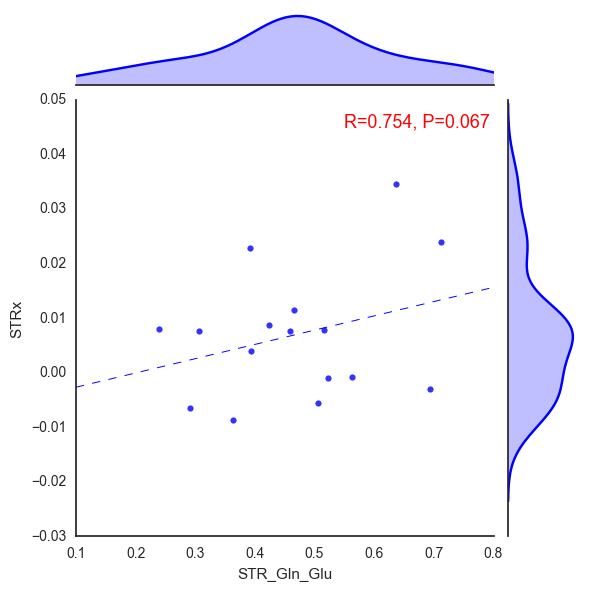

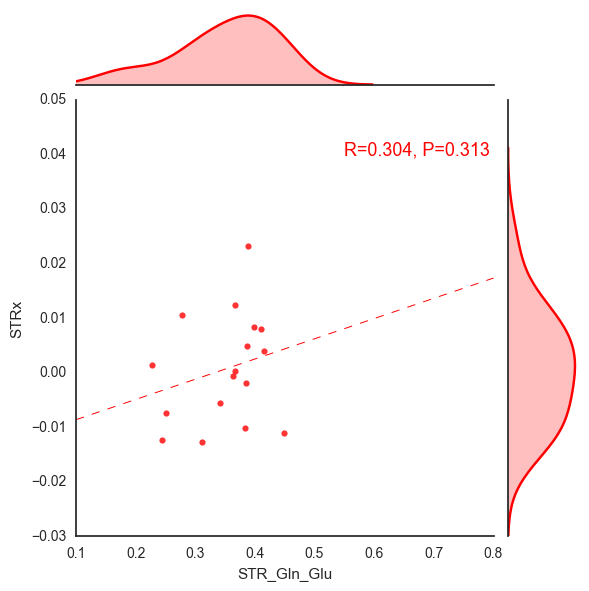

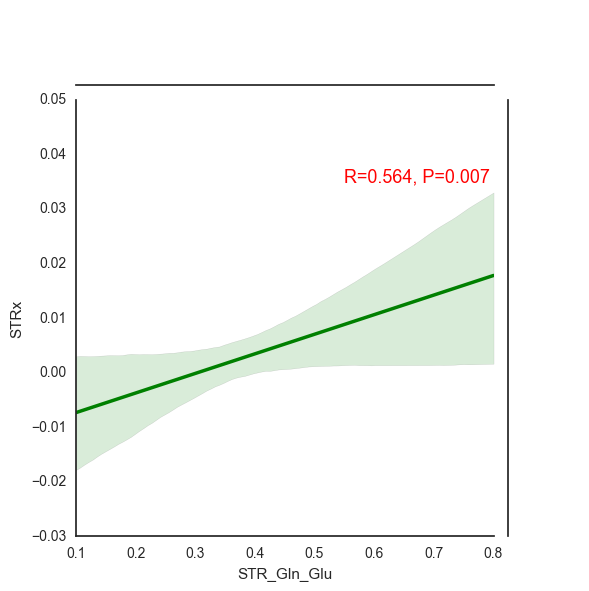

In [225]:
drp = ['KDDP', 'TT3P', 'YU1P']
drc = []

df = DF_ALL.drop(drp+drc ,axis=0)
x = 'STR_Gln_Glu'
y = 'STRx'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
xlim  = (0.1, 0.8)
ylim  =(-.03,0.05)
dpi = 500 

print gESD_outliers(patients_a, x, alpha = .05)
print gESD_outliers(controls_a, x, alpha = .05)
print gESD_outliers(patients_a, y, alpha = .05)
print gESD_outliers(controls_a, y, alpha = .05)

plot_partial_correlation(controls_a.drop(drc,axis=0), x, y, regressors = regressorsx, color = 'b', ci = None,
                         labels = False, annotate = (0.55,0.045), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                         fig_name = 'GLUIRON_STRx_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', ci = None,
                         labels = False,annotate = (0.55,0.04), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_STRx_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate =(0.55,0.035), 
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_STRx_STRGlnGLu_reg_agegender_ALL.png'
                        )




[]
[]
[]
['BH5T']


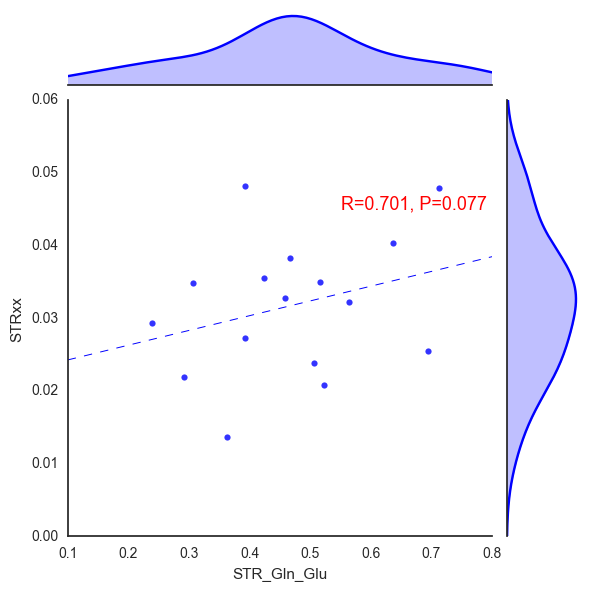

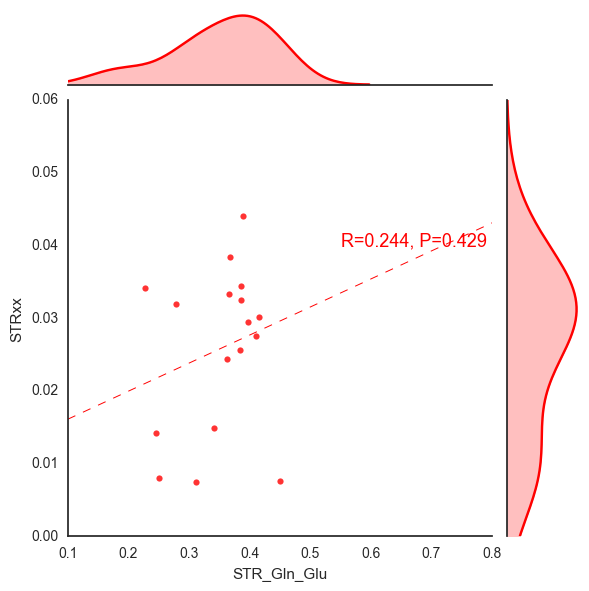

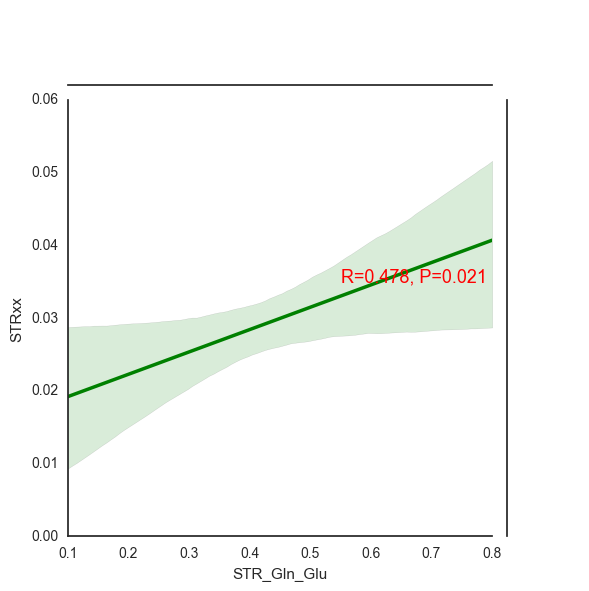

In [224]:
drp = ['KDDP', 'TT3P', 'YU1P']
drc = []

df = DF_ALL.drop(drp+drc ,axis=0)
x = 'STR_Gln_Glu'
y = 'STRxx'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
xlim  = (0.1, 0.8)
ylim  = (0,0.06)
dpi = 500 

print gESD_outliers(patients_a, x, alpha = .05)
print gESD_outliers(controls_a, x, alpha = .05)
print gESD_outliers(patients_a, y, alpha = .05)
print gESD_outliers(controls_a, y, alpha = .05)

plot_partial_correlation(controls_a.drop(drc,axis=0), x, y, regressors = regressorsx, color = 'b', ci = None,
                         labels = False, annotate = (0.55,0.045), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                         fig_name = 'GLUIRON_STRxx_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', ci = None,
                         labels = False,annotate = (0.55,0.04), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_STRxx_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate =(0.55,0.035), 
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_STRxx_STRGlnGLu_reg_agegender_ALL.png'
                        )





Grubbs Outliers [] ['BH5T']
gESD Outliers [] ['BH5T', 'PU2T', 'TR4T']
Grubbs Outliers [] []
gESD Outliers [] []
Grubbs Outliers [] ['BH5T']
gESD Outliers [] []


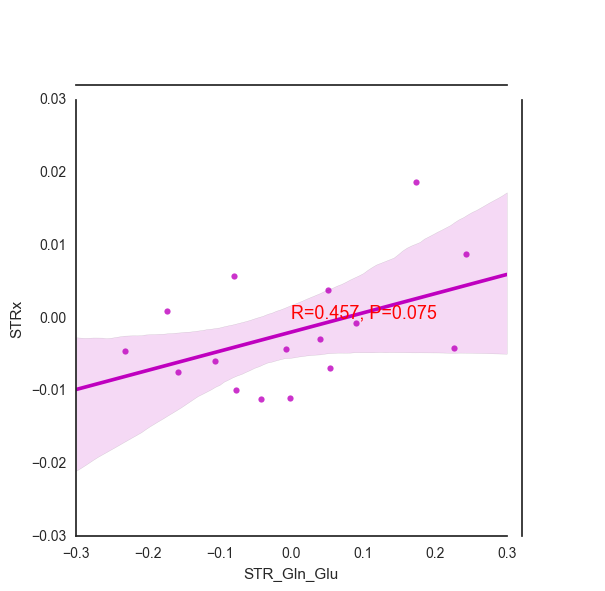

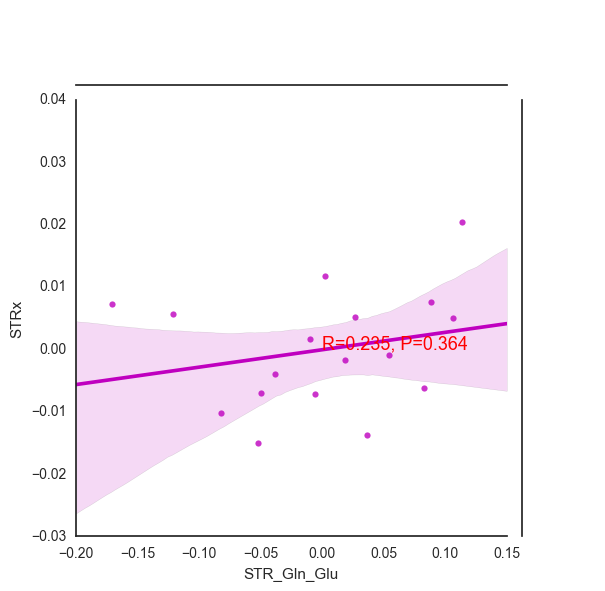

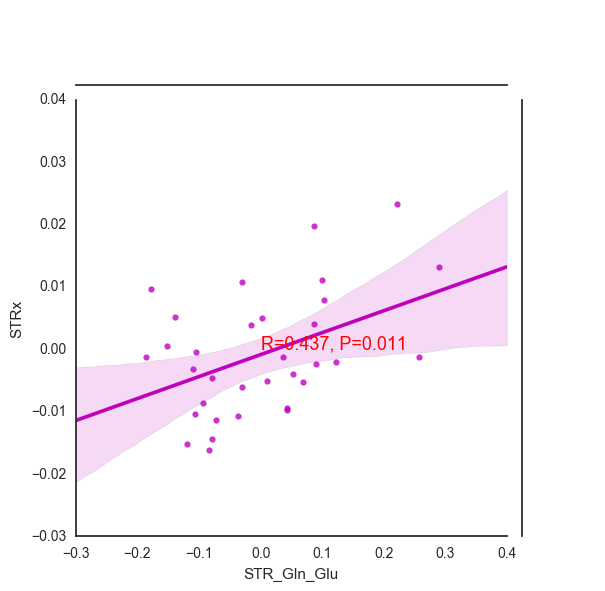

In [121]:
drp = ['KDDP', 'TT3P', 'YU1P']


df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'STRx'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
xlim  = None#(-.3,.4)#(-.075,.1750)
ylim  = None#(-.1, .1)

plt_resid(controls_a, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0,0), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

plt_resid(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0,0), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )


plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0,0), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

In [46]:
def get_resid(df,measure, regressors):
        formula = [ '%s ~ %s'%(measure,regressors[0])  + ' + %s'%regressor for regressor in regressors[1:]][0]#  
        res= smf.ols(formula=formula, data= df).fit().resid
        return res #+ np.mean(df[measure].dropna())
    
    
def plt_resid(data, x, y, regressors = None, color = None, annotate = None, fig_name = None, 
              dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
              plot_marg = 1, xlim = None, ylim = None):
    
    x_resid = get_resid(data,x, regressorsx)
    y_resid = get_resid(data,y, regressorsx)
    print 'Grubbs Outliers', grubbs_outliersx(x_resid), grubbs_outliersx(y_resid)
    print 'gESD Outliers',gESD_outliersx(x_resid),gESD_outliersx(y_resid)
    df = pd.concat([x_resid, y_resid], axis=1).dropna()
    df.columns = [x,y]
    
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    formula = [ '%s ~ %s'%(y,x)][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')

    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)


# Correlation between STN-Chi & STR-Gln:Glu 

### Linear fit with no regressors 

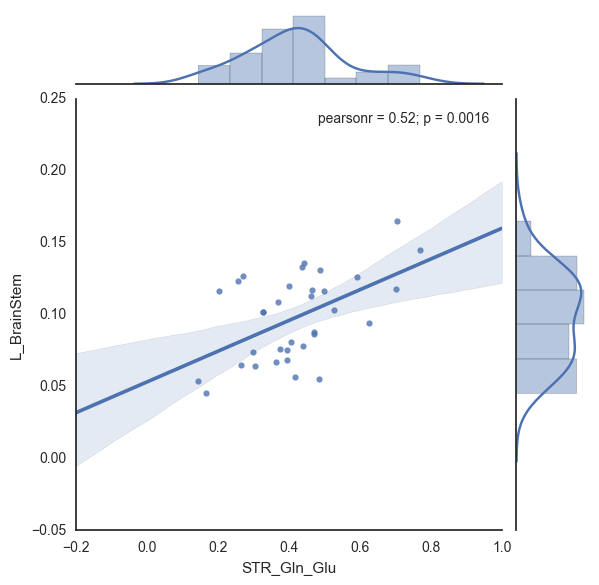

In [53]:
df = DF_ALL.drop(['SA5U','KDDP'],axis=0)
x = 'STR_Gln_Glu'
y = 'L_BrainStem'
plot_joint(df,x,y, drop = [])

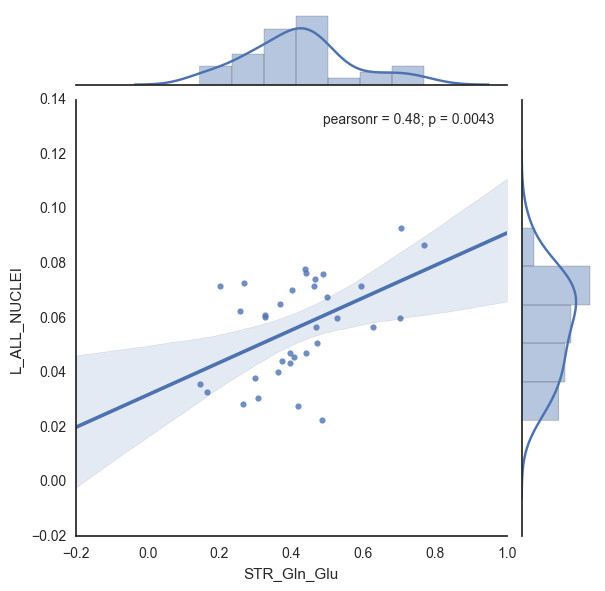

In [49]:
df = DF_ALL.drop(['SA5U','KDDP'],axis=0)
x = 'STR_Gln_Glu'
y = 'L_ALL_NUCLEI'
plot_joint(df,x,y, drop = [])

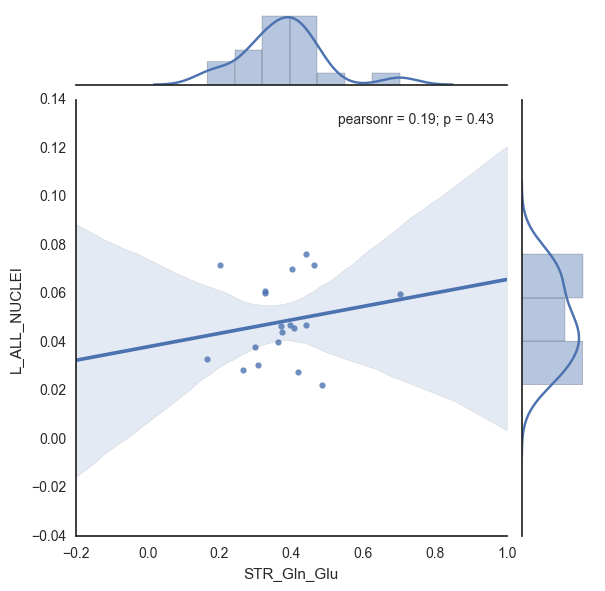

In [54]:
df = patients_a.drop(['KDDP'],axis=0)
x = 'STR_Gln_Glu'
y = 'L_ALL_NUCLEI'
plot_joint(df,x,y, drop = [])

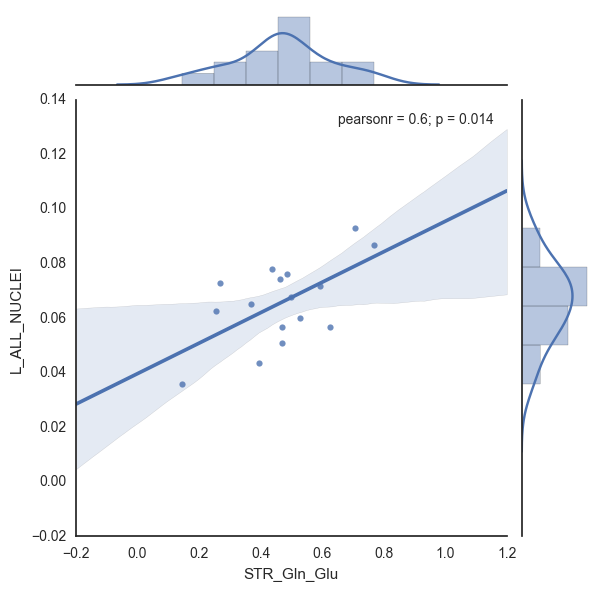

In [55]:
df = controls_a.drop([],axis=0)
x = 'STR_Gln_Glu'
y = 'L_ALL_NUCLEI'
plot_joint(df,x,y, drop = [])

## Linear fit with Age/Gender regressed from y axis

In [6]:
print grubbs_outliers(patients_a, 'STR_Gln_Glu', alpha = .05)
print grubbs_outliers(controls_a, 'STR_Gln_Glu', alpha = .05)
print grubbs_outliers(patients_a, 'L_STN', alpha = .05)
print grubbs_outliers(controls_a, 'L_STN', alpha = .05)
print grubbs_outliers(patients_a, 'L_Puta', alpha = .05)
print grubbs_outliers(controls_a, 'L_Puta', alpha = .05)

[]
[]
[]
[]
[]
[]


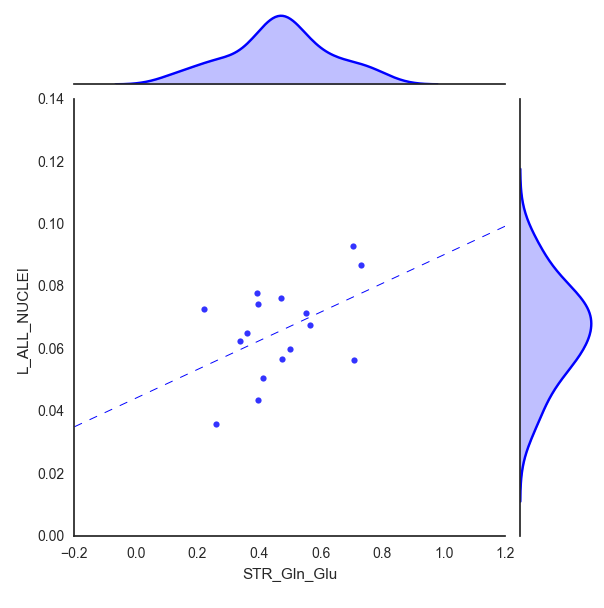

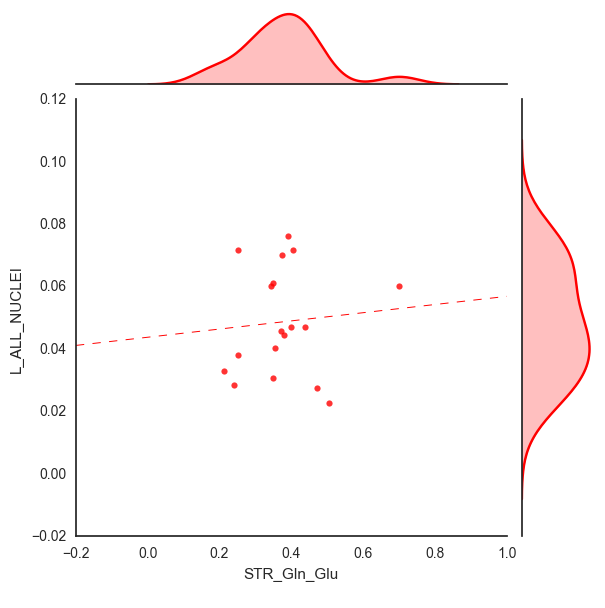

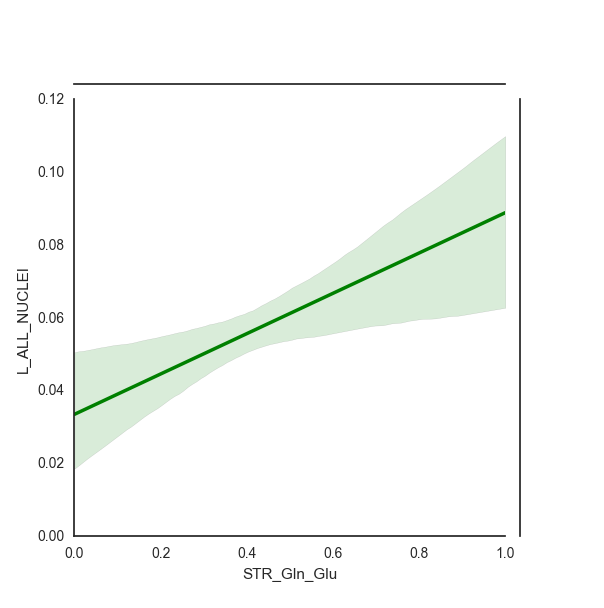

In [62]:
drp = ['SA5U', 'KDDP']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_ALL_NUCLEI'
regressorsx = ['Gender', 'QI1_MAG']
xlim  = None#(0, 1)
ylim  = None#(-.05,.1750)
dpi = 500 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', ci = None,
                         labels = False, annotate = (0.6,0.15), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', ci = None,
                         labels = False,annotate = (0.6,0.14), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate =(0.6,0.13), 
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_agegender_ALL.png'
                        )


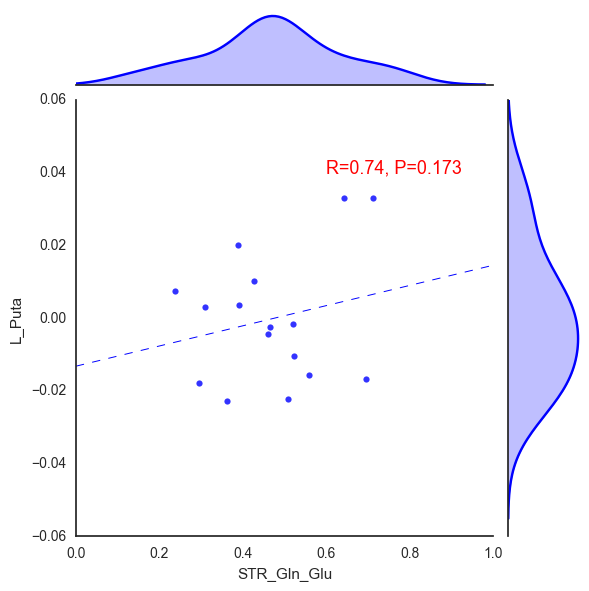

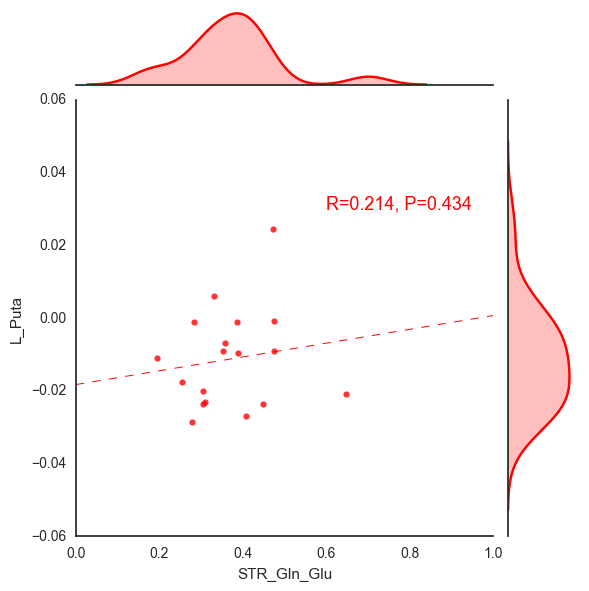

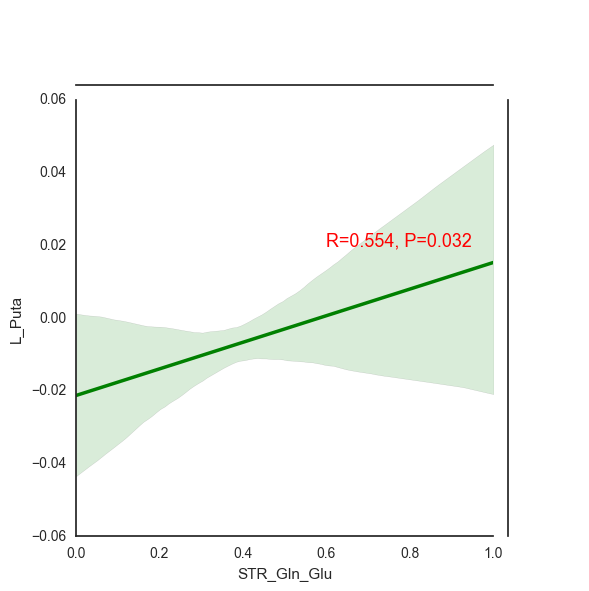

In [360]:
drp = ['SA5U', 'KDDP','YU1P']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_Puta'
regressorsx = ['Age', 'Gender']
xlim  = (0, 1)
ylim  = (-.06,.06)
dpi = 500 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', ci = None,
                         labels = False, annotate = (0.6,0.04), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                         fig_name = 'GLUIRON_LPut_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', ci = None,
                         labels = False,annotate = (0.6,0.03), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_LPut_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (0.6,0.02), 
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'GLUIRON_LPut_STRGlnGLu_reg_agegender_ALL.png'
                        )


### Linear fir with Age/Gender regressed from both axes

In [54]:
drp = ['SA5U', 'KDDP','YU1P']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_ALL_NUCLEI'
regressorsx = ['Age', 'Gender']
xlim  = None#(-.3,.4)#(-.075,.1750)
ylim  = None#(-.1, .1)

plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0,0.02), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

NameError: name 'dpi' is not defined

In [68]:
DF_ALL.L_ALL_NUCLEI * 100

SMVX    4.360662
SS1X    3.582704
STQT    5.075604
HM1X    5.703025
TR4T    6.876425
FA2T    7.135175
PAHT    5.662554
GSNT    6.250021
RJJT    5.653304
KO4T    7.624267
SDCT    6.781579
HM2X    7.274738
MJBT    7.786054
GHAT    8.686462
EC9T    6.524400
RA7T    7.516250
PU2T    9.297621
TJ5T    7.445904
BH5T    9.232375
LMIT    6.010429
TV1T    7.764942
RMNT    7.158342
BE9P    4.029471
HJEP    4.712508
BATP    6.026500
LA9P    3.298046
RMJP    4.714908
LT5P    4.432712
CM5P    2.847796
CF1P    7.187442
SM6U    3.807608
RL7P    7.167225
SGKP    2.758658
HHQP    6.103421
SA5U    4.656867
THCP    5.460242
PC5P    3.082875
SBQP    7.634913
NT6P    4.581842
TT3P    6.007100
CB4P    5.088896
YU1P    2.251350
SULP    7.020508
KDDP    5.145721
Name: L_ALL_NUCLEI, dtype: float64

# '##################################################################'
# '##################################################################'
# '##################################################################'

# Relationships with Ferritin

In [12]:
print grubbs_outliers(patients_a, 'CLN_Ferritin', alpha = .05)
print grubbs_outliers(controls_a, 'CLN_Ferritin', alpha = .05)
print grubbs_outliers(patients_a, 'BrainStem', alpha = .05)
print grubbs_outliers(controls_a, 'BrainStem', alpha = .05)
print grubbs_outliers(patients_a, 'BasalGanglia', alpha = .05)
print grubbs_outliers(controls_a, 'BasalGanglia', alpha = .05)

['SA5U', 'DF2P']
[]
[]
[]
[]
['BH5T']


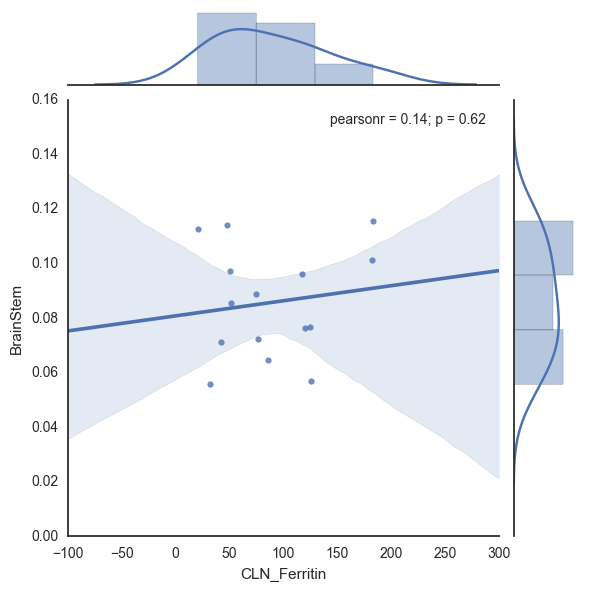

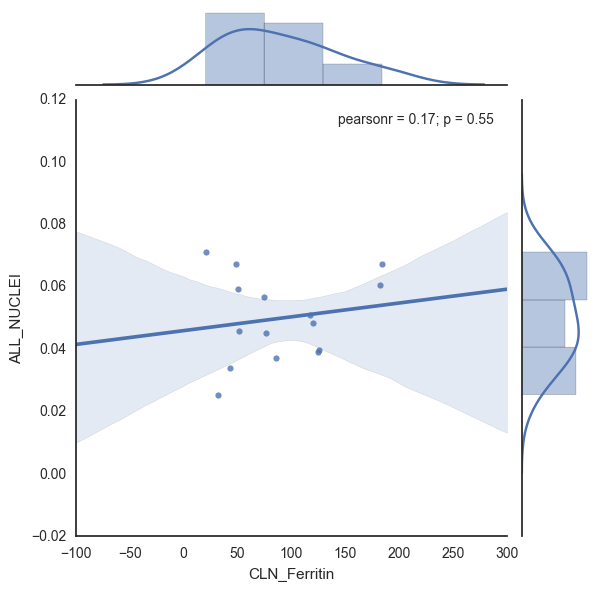

In [164]:
drp = [ 'SA5U'] # pu2t outlier in Brainstem
df = patients_a.drop(drp,axis=0)
y = 'BrainStem'
x = 'CLN_Ferritin'
plot_joint(df,x,y, drop = [])

y = 'ALL_NUCLEI'
x = 'CLN_Ferritin'
plot_joint(df,x,y, drop = [])

In [130]:
controls_a.BrainStem * 100

SMVX     6.277883
SS1X     6.540817
STQT     8.770450
HM1X     9.706533
TR4T    11.530167
FA2T    10.537467
PAHT     8.549400
GSNT    12.186067
RJJT     9.095567
KO4T    12.829100
SDCT    11.574500
HM2X    12.104300
MJBT    13.333450
GHAT    13.767533
EC9T    11.383250
RA7T    12.336767
PU2T    16.251250
TJ5T    12.485133
BH5T    13.430150
LMIT    10.092567
TV1T    12.958883
RMNT    12.989567
Name: BrainStem, dtype: float64

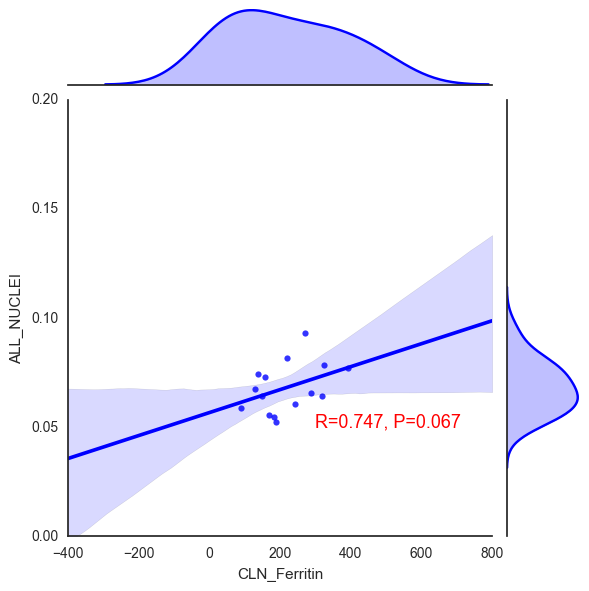

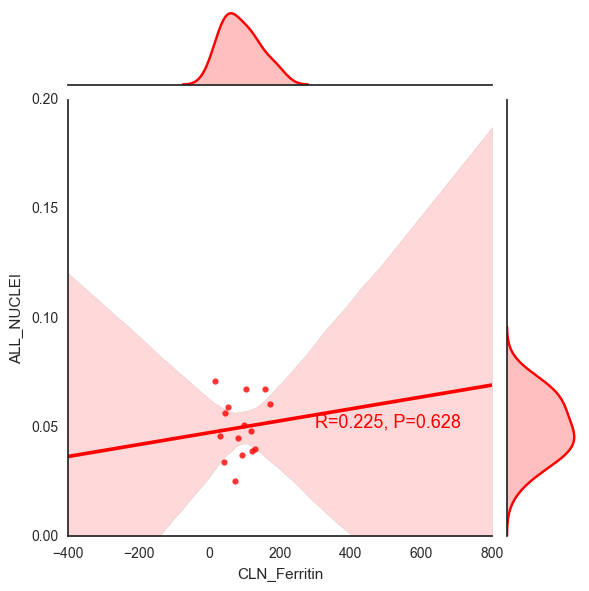

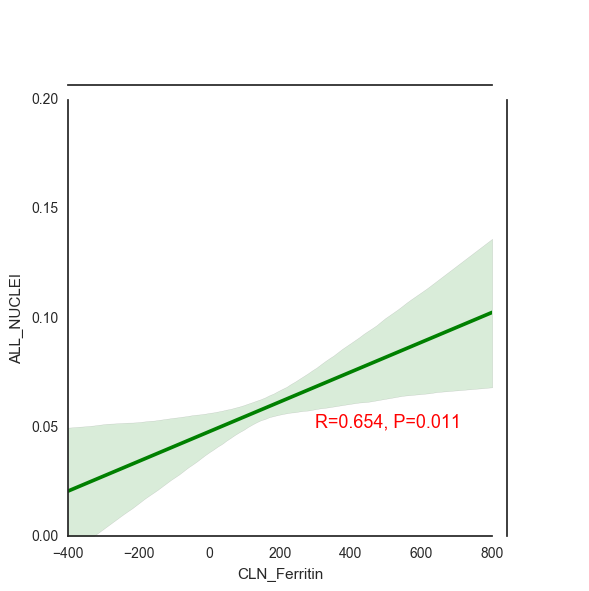

In [156]:
drp = ['SA5U','PU2T']
df = DF_ALL.drop(drp,axis=0)
y = 'ALL_NUCLEI'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender']
ylim  =(0,.2)#(-.075,.1750)
xlim  = (-400, 800)
dpi = 500 
plot_partial_correlation(controls_a.drop(['PU2T', 'SMVX'],axis=0), x, y, regressors = regressorsx, color = 'b', 
                         labels = False,annotate = (300,0.05),  
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                         #fig_name = 'FERR_BRAINSTEM_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(['SA5U'],axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = (300,0.05),  
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'FERR_BRAINSTEM_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (300,0.05),  
                         fit_reg=1, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'FERR_BRAINSTEM_reg_age_gender_all.png'
                        )

Grubbs Outliers [] ['YU1P']
gESD Outliers [] []


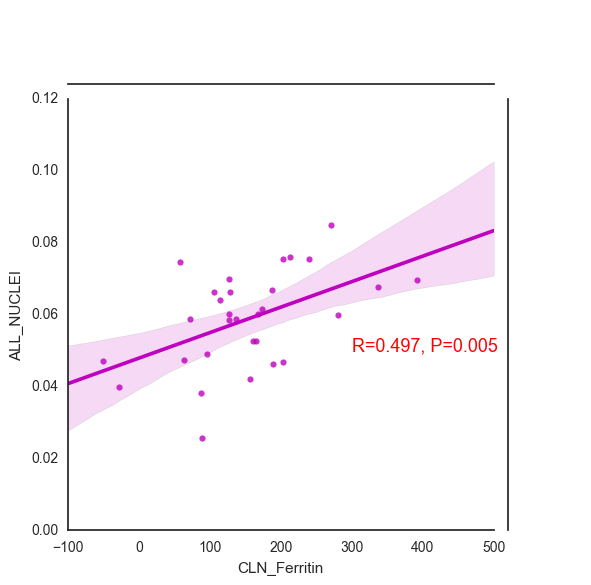

In [135]:
drp = ['SA5U', 'PU2T', 'SMVX']
df = DF_ALL.drop(drp,axis=0)
y = 'ALL_NUCLEI'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
xlim  = None#(-.3,.4)#(-.075,.1750)
ylim  = None#(-.1, .1)

plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (300,0.05), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

Grubbs Outliers [] []
gESD Outliers [] []


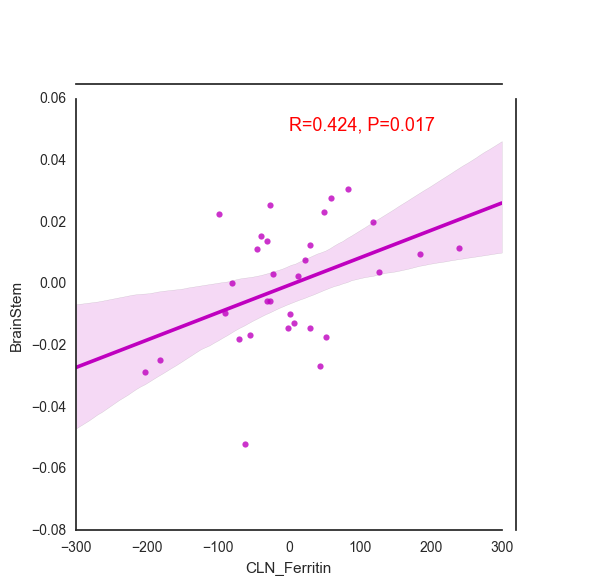

In [142]:
drp = ['SA5U', 'PU2T', ]
df = DF_ALL.drop(drp,axis=0)
y = 'BrainStem'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
xlim  = None#(-.3,.4)#(-.075,.1750)
ylim  = None#(-.1, .1)

plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0,0.05), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

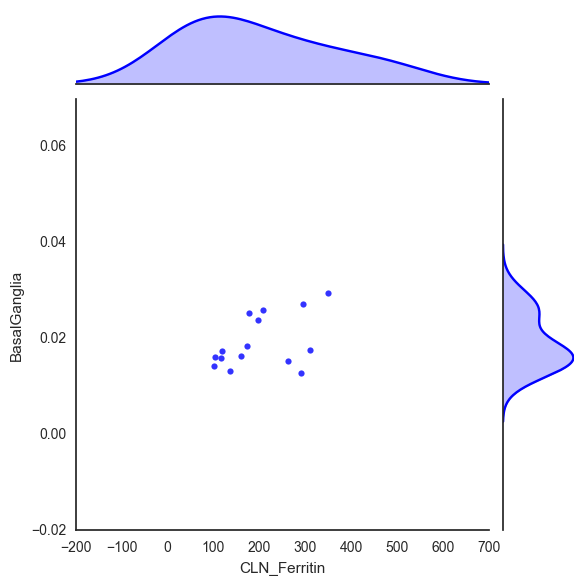

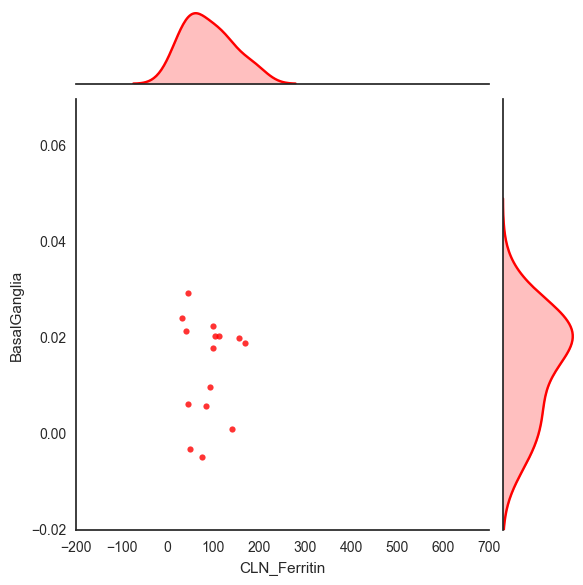

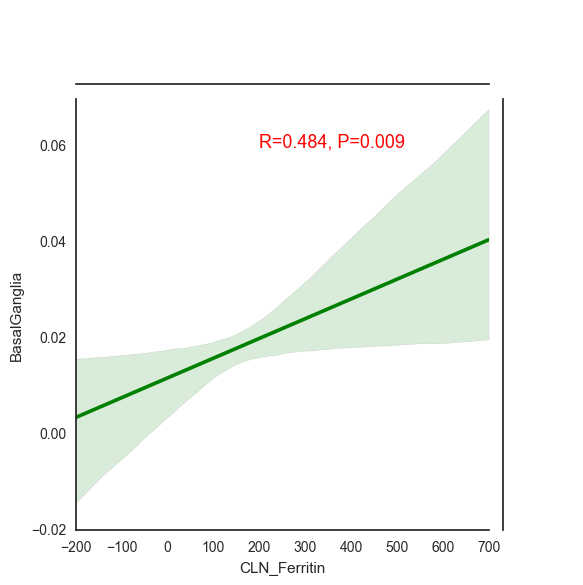

In [47]:
drp = [ 'SA5U']
df = DF_ALL.drop(drp,axis=0)
y = 'BasalGanglia'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
ylim  = (-0.02,.07)
xlim  = (-200, 700)
dpi = 500 
plot_partial_correlation(controls_a.drop(['BH5T', 'PU2T'],axis=0), x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = 0,#(400,0.2), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                        # fig_name = 'FERR_BASAL_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(['SA5U'],axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = 0,#(400,0.14), 
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                         #fig_name = 'FERR_BASAL_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (200,0.06),  
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'FERR_BASAL_reg_age_gender_all.png'
                        )

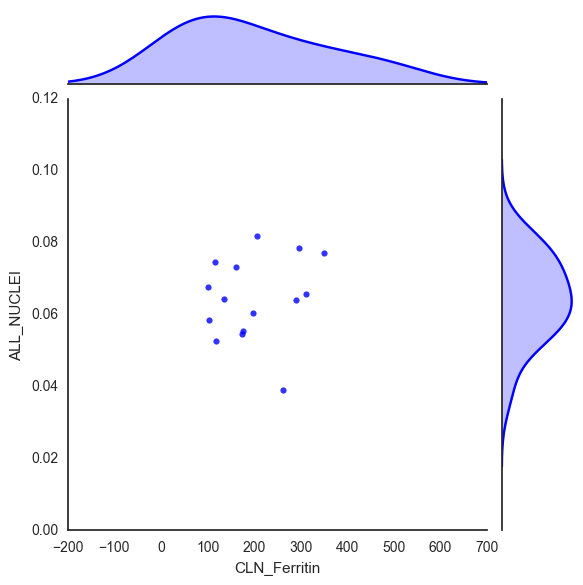

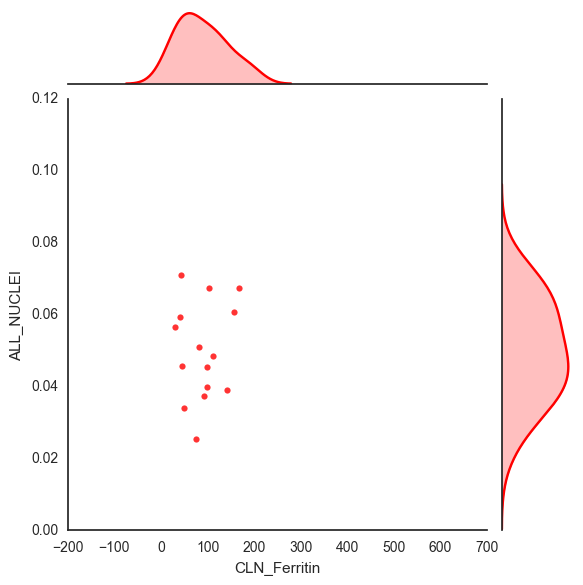

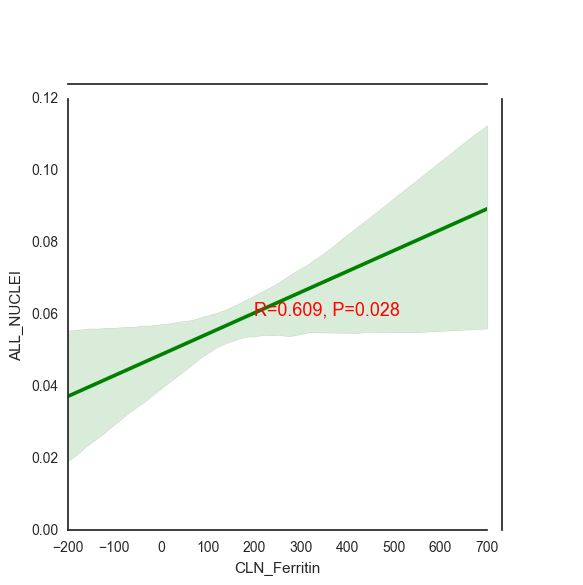

In [44]:
drp = ['PU2T', 'SA5U', 'BH5T']
df = DF_ALL.drop(drp,axis=0)
y = 'ALL_NUCLEI'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
ylim  = (0,.12)
xlim  = (-200, 700)
dpi = 500

plot_partial_correlation(controls_a.drop(['BH5T', 'PU2T'],axis=0), x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = 0,#(400,0.2), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                         fig_name = 'FERR_ALL_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(['SA5U'],axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = 0,#(400,0.14), 
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'FERR_ALL_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (200,0.06),  
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                         fig_name = 'FERR_ALL_reg_age_gender_all.png'
                        )

In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('CLN_Ferritin ~ Age + Gender', data=df, return_type='dataframe')
thresh = 5.0
variables = range(X.shape[1])

for i in np.arange(0,len(variables)):
    vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
    print(vif)
    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
        del variables[maxloc]

print('Remaining variables:')
print(X.columns[variables])

[10.393250415374572, 1.0024843272993265, 1.0024843272993265]
dropping 'Intercept' at index: 0
[1.1553740896049436, 1.1553740896049436]
[1.1553740896049436, 1.1553740896049436]
Remaining variables:
Index([u'Age', u'Gender'], dtype='object')


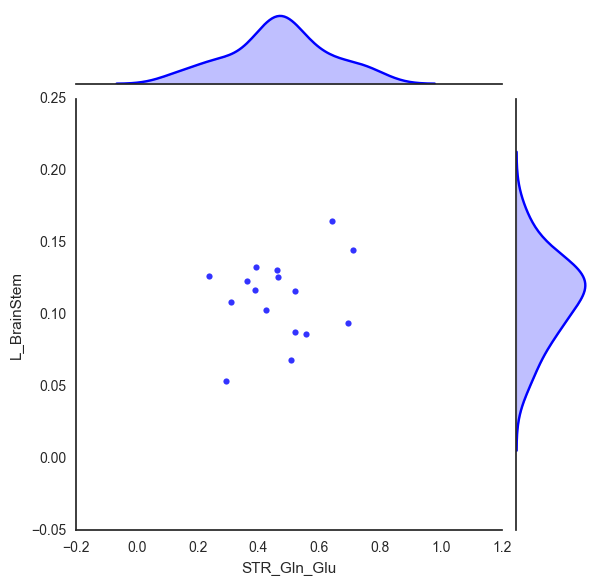

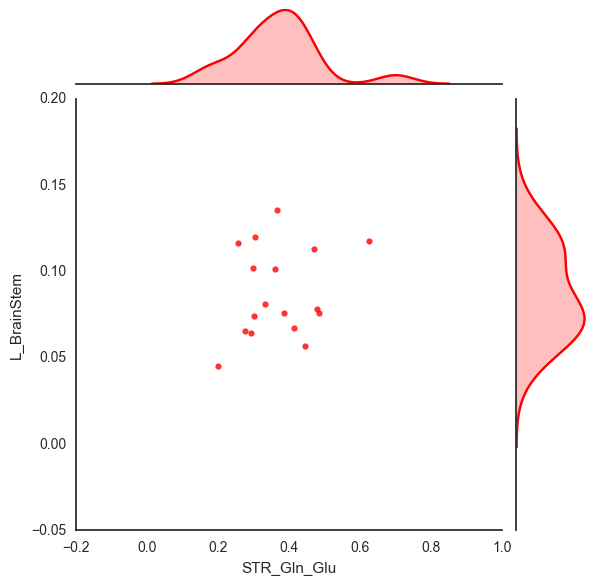

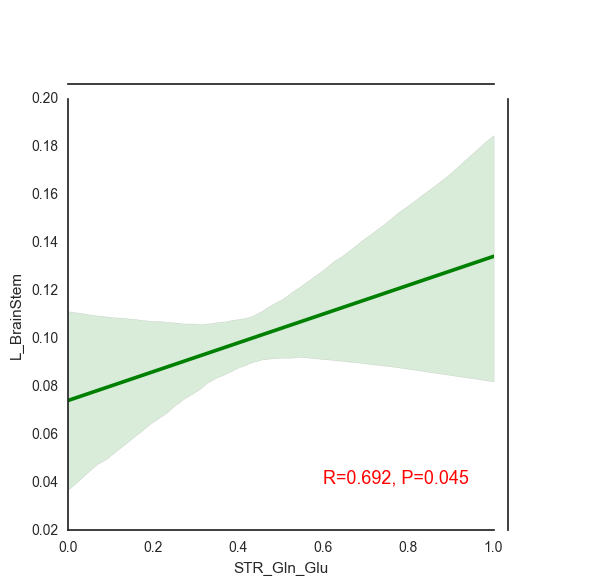

In [34]:
drp = ['SA5U', 'KDDP', 'YU1P']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_BrainStem'
regressorsx = ['Age', 'Gender']
xlim  = None#(0, 1)
ylim  = None#(-.075,.1750)
dpi = 500 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = 0,#(-0.075,1.15), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = 0,#(-0.075,1.075),
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,

                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (0.6,0.04), 
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        
                        )
